In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pyccl as ccl
import numpy as np
from scipy.integrate import odeint

from nDGPemu import BoostPredictor
import sys, platform, os
import matplotlib.pyplot as plt
import matplotlib

MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)

from MGCAMB import camb


# Get boosts nDGP (testing only for one cosmo)

In [2]:
model = BoostPredictor()
cosmo_params = {'Om':0.3,
                'ns':0.96,
                'As':2.01e-9,
                'h':0.67,
                'Ob':0.05}
k_vals = model.k_vals
Bk = model.predict(0.2, 0, cosmo_params, k_out=k_vals)


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0, 0.5, '$B_{\\rm nDGP}(k)$')

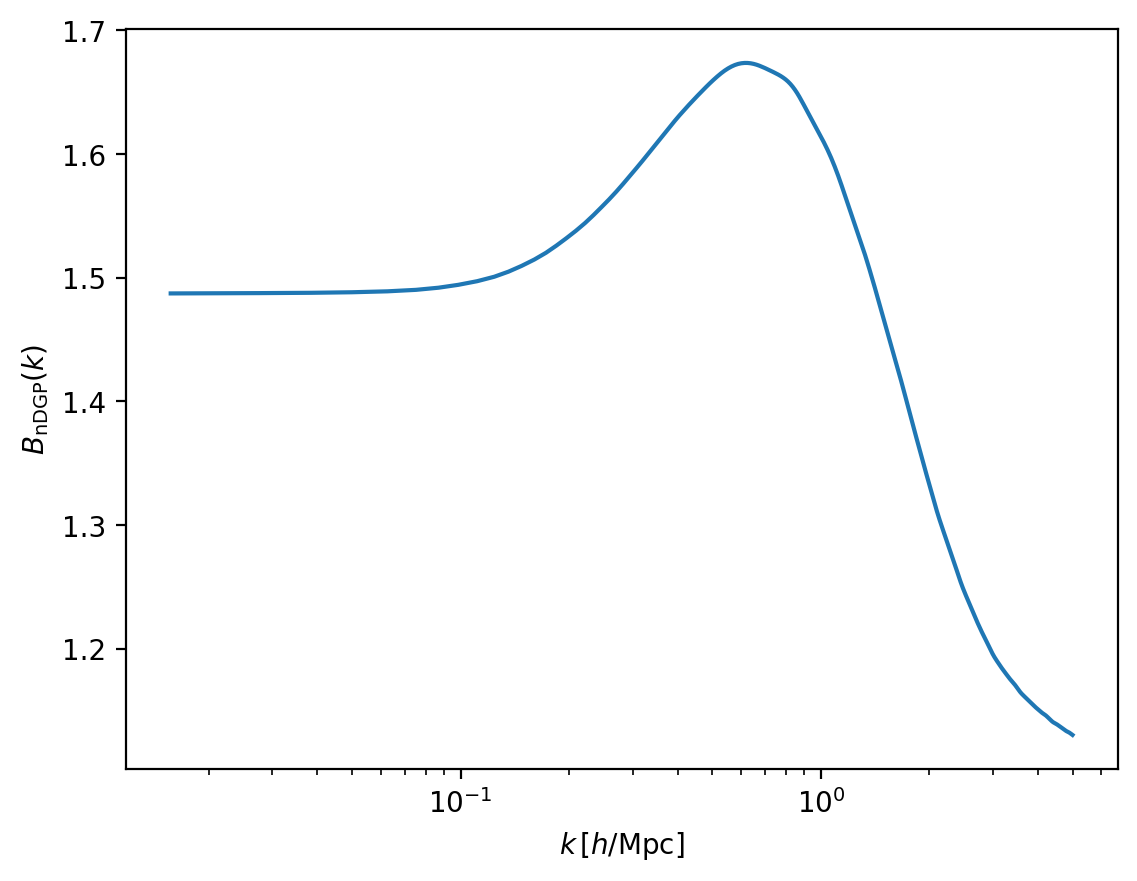

In [3]:
plt.semilogx(k_vals, Bk)
plt.xlabel(r'$k \, [h/{\rm Mpc}]$')
plt.ylabel(r'$B_{\rm nDGP}(k)$')


# Define cosmo params

In [4]:
H0rc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)
print(H0rc_arr)
n_s_arr = np.ones(12)*0.9665
wm_arr = np.ones(12)*0.1417493400784
A_s_arr = np.ones(12)*2.01e-9
h_val = 0.67
Omega_b_val = 0.0223/0.67**2

cosmo = ccl.Cosmology(Omega_c = wm_arr[0]/h_val**2 - Omega_b_val,
                           Omega_b =  Omega_b_val,
                           h = h_val,
                           n_s = n_s_arr[0],
                           A_s = A_s_arr[0])

sigma8_val = ccl.power.sigmaR(cosmo, 8, a=1)

sigma8_arr_gr = np.ones(12)*sigma8_val
print(sigma8_val)

arr_params = np.array([H0rc_arr,n_s_arr,wm_arr,np.zeros(len(sigma8_arr_gr)), A_s_arr])
#print(arr_params.shape)

[ 0.2         0.30391859  0.46183255  0.7017975   1.06644653  1.62056464
  2.46259862  3.74214753  5.68654104  8.64122772 13.13114881 19.95400128]
1.0431869707460153


# Get linear power spectrum from MGCAMB

## Get growth

In nDGP, the background evolution can be written as:

$H(a) = H_0 \sqrt{\Omega_{m0} a^{-3} + \Omega_{rc}} + \sqrt{\Omega_{rc}}$

And to linear order, the matter density perturbation follows the equation:

$\ddot{\delta} + 2H\dot{\delta} - 4 \pi G_{eff} \rho\delta = 0$, with $G_{eff}/G = \frac{2(1+2\Omega_m^2(a))}{3(1+\Omega_{m}^2(a))}$

In [49]:
print(cosmo["Omega_c"])

0.2660934285551348


In [6]:
# dimensionless hubble parameter in nDGP
def E_nDGP(Omg_rc, cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmo["Omega_m"]/a**3 +Omg_r/a**4 + Omg_rc + (1 - cosmo["Omega_m"] - Omg_r)) + np.sqrt(Omg_rc)

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E_nDGP(0, cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

Text(0.5, 0, 'z')

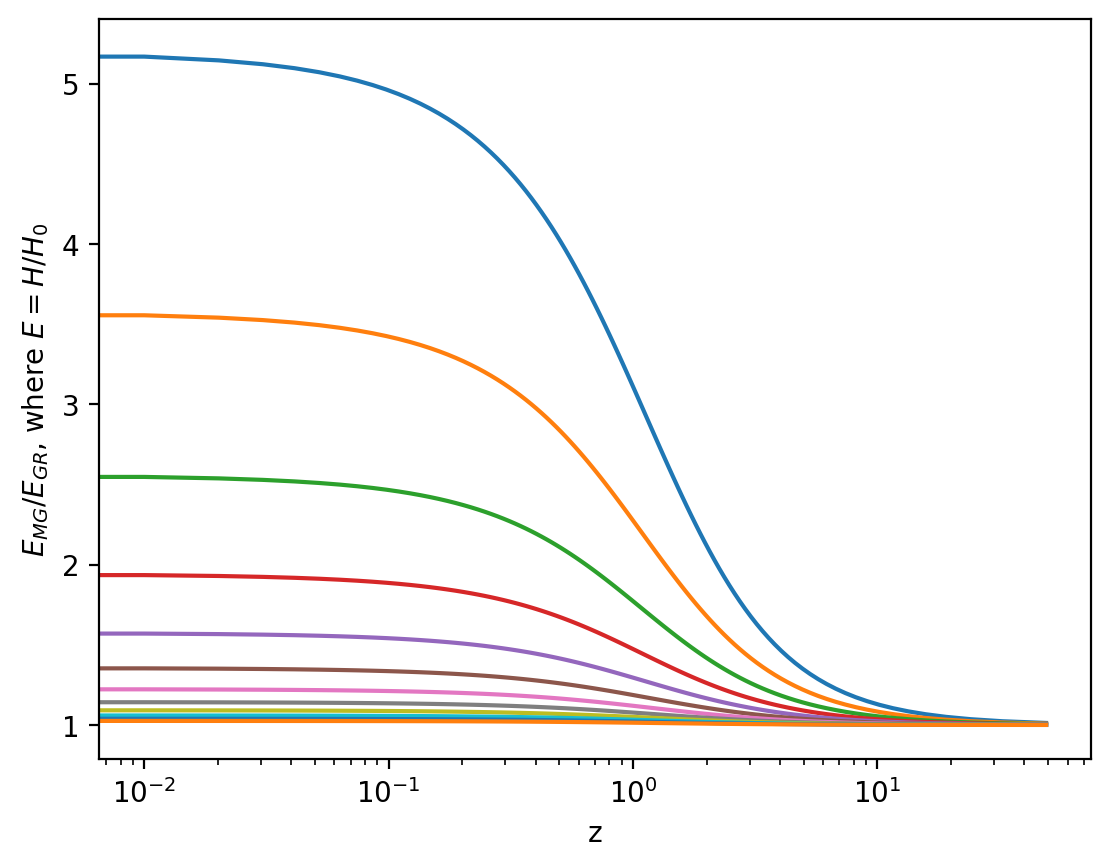

In [7]:
a = np.linspace(1/50,1,100)

for i in range(len(H0rc_arr)):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    Omg_rc = 1/(4*H0rc_arr[i]**2)
    plt.plot(1/a -1 , E_nDGP(Omg_rc, cosmo, a)/np.sqrt(cosmo["Omega_m"]/a**3 +Omg_r/a**4 +  (1-cosmo["Omega_m"] -Omg_r/a**4 )))

plt.xscale("log")
plt.ylabel("$E_{MG}/E_{GR}$, where $E=H/H_0$")
plt.xlabel("z")

In [8]:
def Geff_v_G(Omg_rc, cosmo, a):
    return 2 * (1 + 2* (cosmo["Omega_m"]/a**3 / E_nDGP(Omg_rc, cosmo, a)**2)**2) / (3 * (1 + (cosmo["Omega_m"]/a**3 / E_nDGP(Omg_rc, cosmo, a)**2)**2))


# Solves second order ODE for D_+(a)
def solverGrowth(y,a,cosmo, Omg_rc):
    E_val = E_nDGP(Omg_rc, cosmo, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(Geff_v_G(Omg_rc, cosmo, a))/(2*E_val*a**2)]
    return ydot

def Geff_v_G_ReACT(Omg_rc, cosmo, a):
    E_val = E_nDGP(0, cosmo, a)
    beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
    return 1 + 1/3/beta
    
def solverGrowth_ReACT(y,a,cosmo, Omg_rc):
    E_val = E_nDGP(0, cosmo, a)
    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(Geff_v_G_ReACT(Omg_rc, cosmo, a))/(2*E_val*a**2)]
    return ydot

Text(0.5, 0, 'z')

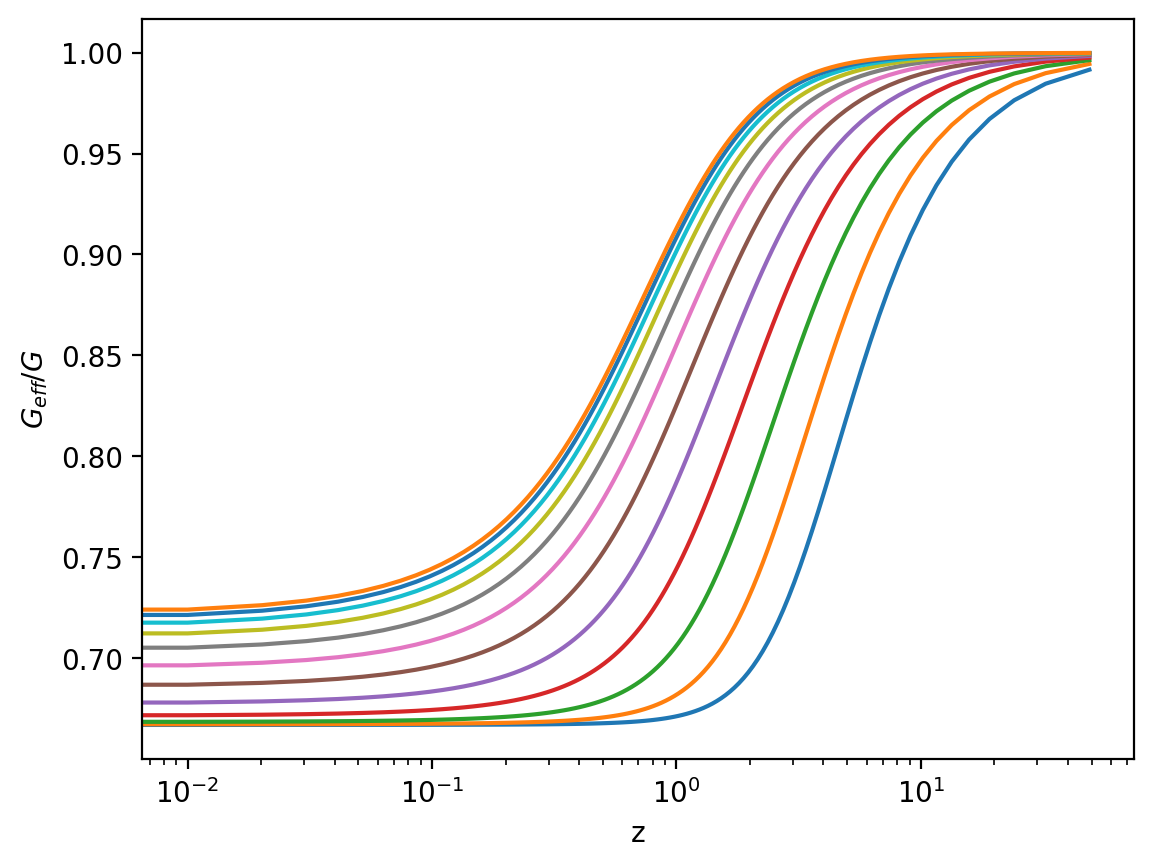

In [9]:
for i in range(len(H0rc_arr)):
    Omg_rc = 1/(4*H0rc_arr[i]**2)
    plt.plot(1/a -1 , Geff_v_G(Omg_rc, cosmo, a))

plt.xscale("log")
plt.ylabel("$G_{eff}/G$")
plt.xlabel("z")

In [10]:
# SOLUTION
Omega_rc = (1/(4*H0rc_arr**2))
Delta = np.zeros((len(Omega_rc),len(a)))

"""
for i in range(len(Omega_rc)):
    Soln = odeint(solverGrowth, [a[0], (E_nDGP(Omega_rc[i], cosmo, a[0])*a[0]**3)], a, args=(cosmo,Omega_rc[i]), mxstep=int(1e4))
    Delta[i] = Soln.T[0]/Soln.T[0][-1]
"""
for i in range(len(Omega_rc)):
    Soln = odeint(solverGrowth_ReACT, [a[0], (E_nDGP(0, cosmo, a[0])*a[0]**3)], a, args=(cosmo,Omega_rc[i]), mxstep=int(1e4))
    Delta[i] = Soln.T[0]/Soln.T[0][-1]


Soln = odeint(solverGrowth_ReACT, [a[0], (E_nDGP(0, cosmo, a[0])*a[0]**3)], a, args=(cosmo,0), mxstep=int(1e4))
Delta_GR = Soln.T[0]/Soln.T[0][-1]


/tmp/ipykernel_754343/84558177.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)


Text(0, 0.5, '$D_+(z)$')

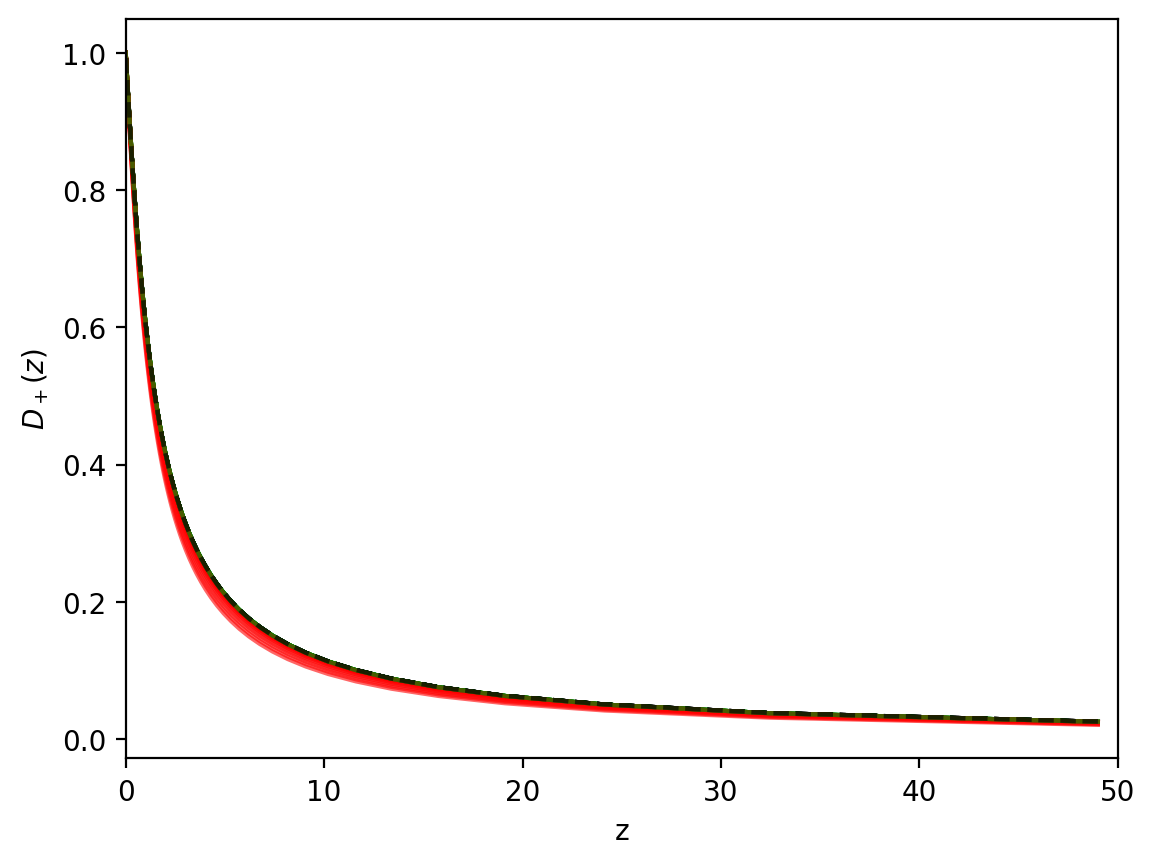

In [11]:
for i in range(len(Omega_rc)):
    plt.plot(1/a-1, Delta[i], label  = r"solved with ODE", color = "r", alpha=0.6)
    plt.plot(1/a-1, Delta_GR, label  = r"solved with ODE", color = "g", alpha=0.6)
    plt.plot(1/a-1, ccl.background.growth_factor(cosmo, a), "k--", alpha=0.6)

plt.xlim(0,50)

plt.xlabel("z")
plt.ylabel("$D_+(z)$")

In [12]:
print(Delta[0][0], Delta_GR[0],ccl.background.growth_factor(cosmo, a)[0])

0.02097960371996341 0.02537248188215153 0.025612295614256608


## Get GR lin from MGCAMB

In [13]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()

#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=12.0)



class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 12.0
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0
 omch2 = 0.0
 omk = 0.0
 omnuh2 = 0.0
 H0 = 67.0
 TCMB = 2.7255
 YHe = 0.24
 num_nu_massless = 3.044
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_delta_neff = False
 nu_mass_degeneracies = []
 nu_mass_fractions = []
 nu_mass_numbers = []
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 0.0
   nrunrun = 0.0
   nt = -0.0
   ntrun = -0.0
   r = 0.0
   pivot_sc

In [14]:
lin_Pk_arr_gr = np.zeros((2,213))

for i in range(1):
    #Linear spectra
    pars.set_cosmology(H0=h_val*100, ombh2=Omega_b_val*h_val**2, omch2=arr_params[2][i] - Omega_b_val*h_val**2, omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=arr_params[1][i], As = arr_params[4][i])
    pars.set_mgparams(MG_flag = 0)
    pars.NonLinear = camb.model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints = 213)
        
    lin_Pk_arr_gr[i+1] = pk
    
lin_Pk_arr_gr[0] = kh

In [15]:
## Power spectrum from CCL 
kk = np.logspace(-3,1,500)*h_val     # in 1/Mpc

Pk_linCCL = ccl.power.linear_matter_power(cosmo, kk, 1)*h_val**3    # in (Mpc)^3/h^3
Pk_NLCCL = ccl.power.nonlin_matter_power(cosmo, kk, 1)*h_val**3    # in (Mpc)^3/h^3

kk = kk/h_val    # in h/Mpc


## Compare with react

In [16]:
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

In [17]:
k_ReACT = arr[0]
pofk_lin_MG_react = arr[13:]
pofk_NL_MG_react = arr[1:13]

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe (i.e. $\approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=0)}\Big)^2P^{nDGP}_{\delta}(z=0)$

Therefore 

$P^{nDGP}_{\delta}(z=0) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$.

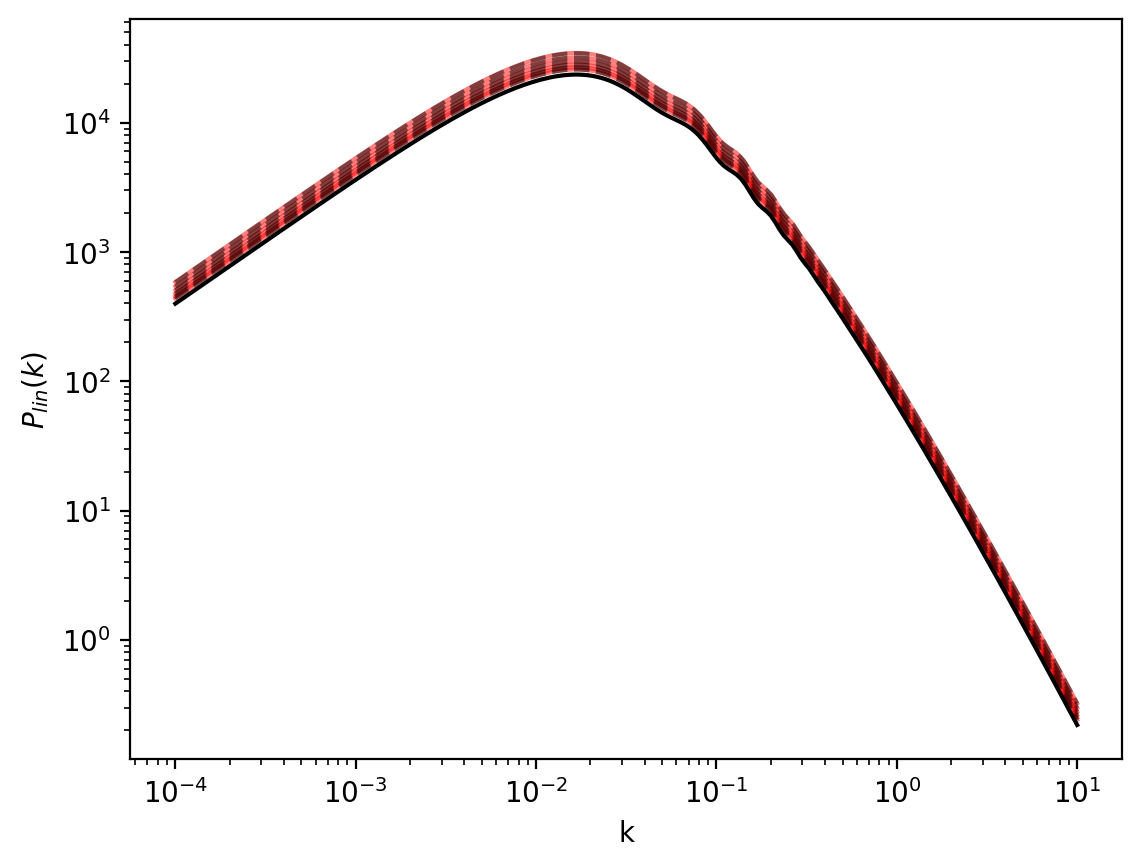

In [18]:
for i in range(6):
    plt.plot(k_ReACT,pofk_lin_MG_react[i], "r",  label= "react", alpha=0.5)
    #plt.plot(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]*(Delta_GR[0]/Delta[i][0])**(-1/3), "b--", label= "MG from growth rate, p=-1/3")
    plt.plot(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]*(Delta_GR[0]/Delta[i][0])**(2), "k--", label= "MG from growth rate, p=2", alpha=0.5)

lin_Pk_arr = np.zeros((len(arr_params[0])+1,213))

for i in range(len(arr_params[0])):
    lin_Pk_arr[i+1] = lin_Pk_arr_gr[1]*(Delta_GR[0]/Delta[i][0])**(2)

lin_Pk_arr[0] = lin_Pk_arr_gr[0]

#plt.plot(kk, Pk_linCCL , color="k", label= "GR")
plt.plot(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1] , color="k", label= "GR")

#plt.legend()
plt.xlabel("k")
plt.ylabel("$P_{lin}(k)$")
plt.xscale("log")
plt.yscale("log")

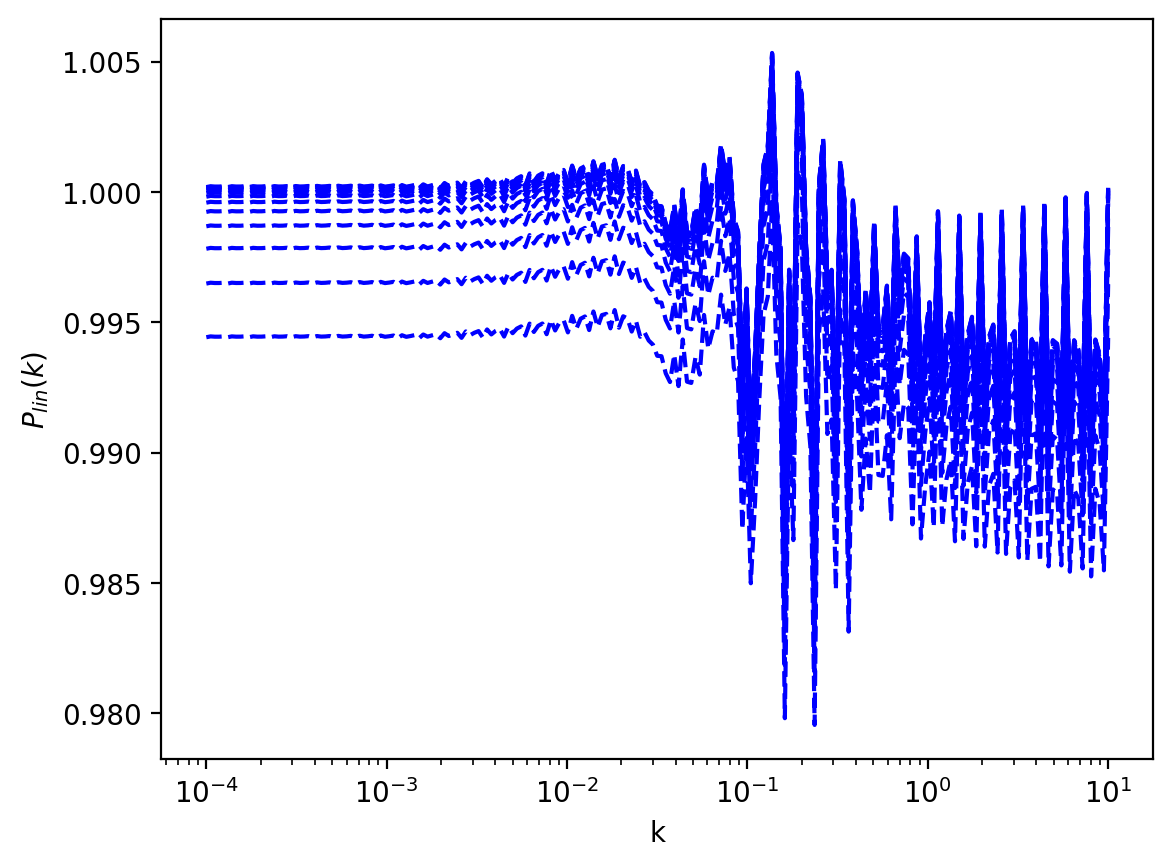

In [19]:
for i in range(len(arr_params[0])):
    plt.plot(lin_Pk_arr_gr[0], (lin_Pk_arr_gr[1]*(Delta_GR[0]/Delta[i][0])**(2))/np.interp(lin_Pk_arr_gr[0],k_ReACT, pofk_lin_MG_react[i]), "b--")

plt.xlabel("k")

plt.ylabel("$P_{lin}(k)$")
plt.xscale("log")


# Non-linear matter power spectrum

In [20]:
n = 1
z = 0

NL_Pk_arr = np.zeros((len(arr_params[0])+1,407))
print(NL_Pk_arr.shape)
print(NL_Pk_arr[0].shape)

for i in range(len(arr_params[0])):
    model = BoostPredictor()
    cosmo_params = {'Om':arr_params[2][i]/h_val**2,
                    'ns':arr_params[1][i],
                    'As':arr_params[4][i],
                    'h':h_val,
                    'Ob':Omega_b_val}
    k = model.k_vals
    pkratio = model.predict(arr_params[0][i], 0, cosmo_params, k_out=k)

    cosmo = ccl.Cosmology(Omega_c = arr_params[2][i]/h_val**2 - Omega_b_val,
                           Omega_b =  Omega_b_val,
                           h = h_val,
                           n_s = arr_params[1][i],
                           A_s = arr_params[4][i])
    # k has units h/Mpc
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*h_val, a=1) # input k with 1/Mpc units, output in Mpc^3 units
    NL_Pk_arr[i+1] = pkratio*Pk_ccl*h_val**3

NL_Pk_arr[0] = k


(13, 407)
(407,)
Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:

NL_Pk_arr_gr = np.zeros((2,407))


for i in range(1):
    cosmo = ccl.Cosmology(Omega_c = arr_params[2][i]/h_val**2 - Omega_b_val,
                           Omega_b =  Omega_b_val,
                           h = h_val,
                           n_s = arr_params[1][i],
                           A_s = arr_params[4][i])
    # k has units h/Mpc
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*h_val, a=1) # input k with 1/Mpc units, output in Mpc^3 units
    NL_Pk_arr_gr[i+1] = Pk_ccl*h_val**3

NL_Pk_arr_gr[0] = k


In [22]:

lin_ccl_Pk_arr_gr = np.zeros((2,407))


for i in range(1):
    cosmo = ccl.Cosmology(Omega_c = arr_params[2][i]/h_val**2 - Omega_b_val,
                           Omega_b =  Omega_b_val,
                           h = h_val,
                           n_s = arr_params[1][i],
                           A_s = arr_params[4][i])
    # k has units h/Mpc
    Pk_ccl = ccl.power.linear_matter_power(cosmo, k*h_val, a=1) # input k with 1/Mpc units, output in Mpc^3 units
    lin_ccl_Pk_arr_gr[i+1] = Pk_ccl*h_val**3

lin_ccl_Pk_arr_gr[0] = k


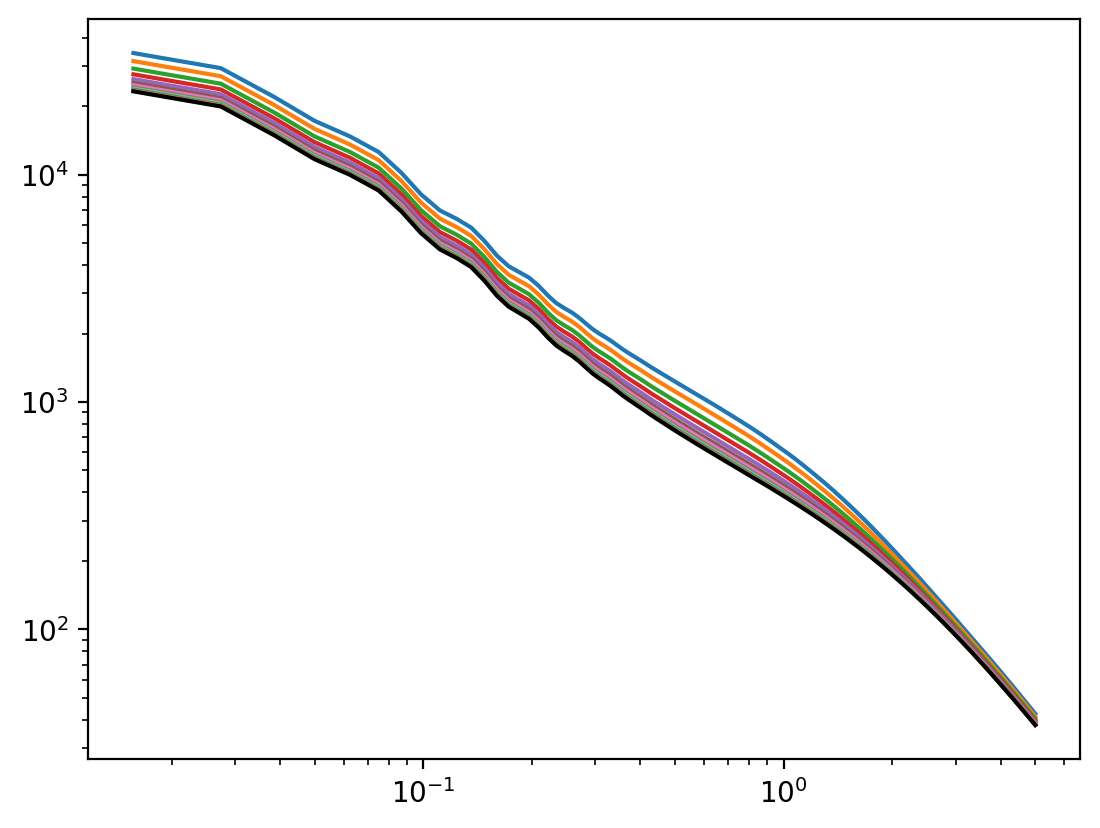

In [23]:
for i in range(len(arr_params[0])):
    plt.plot(NL_Pk_arr[0], NL_Pk_arr[i+1])
    
plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1], color="k")

plt.xscale("log")
plt.yscale("log")

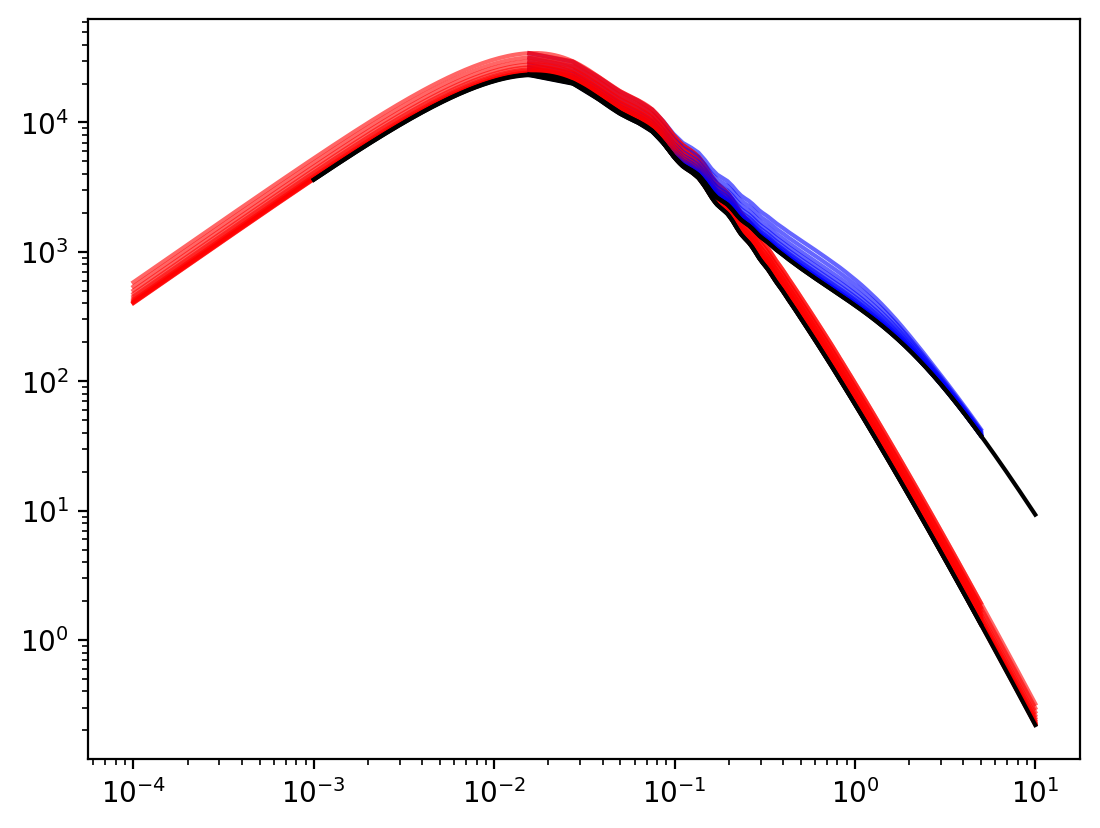

In [24]:
for i in range(len(arr_params[0])):
    plt.plot(NL_Pk_arr[0], NL_Pk_arr[i+1], "b", alpha=0.6)
    plt.plot(lin_Pk_arr[0], lin_Pk_arr[i+1], "r", alpha=0.6)
    plt.plot(NL_Pk_arr[0],np.interp(NL_Pk_arr[0],lin_Pk_arr[0],lin_Pk_arr[i+1]), "r", alpha=0.6)


#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)

plt.plot(kk, Pk_linCCL, "k")
plt.plot(kk, Pk_NLCCL, "k")

plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1] , color="k")
plt.plot(NL_Pk_arr_gr[0], np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]), color="k")

plt.xscale("log")
plt.yscale("log")

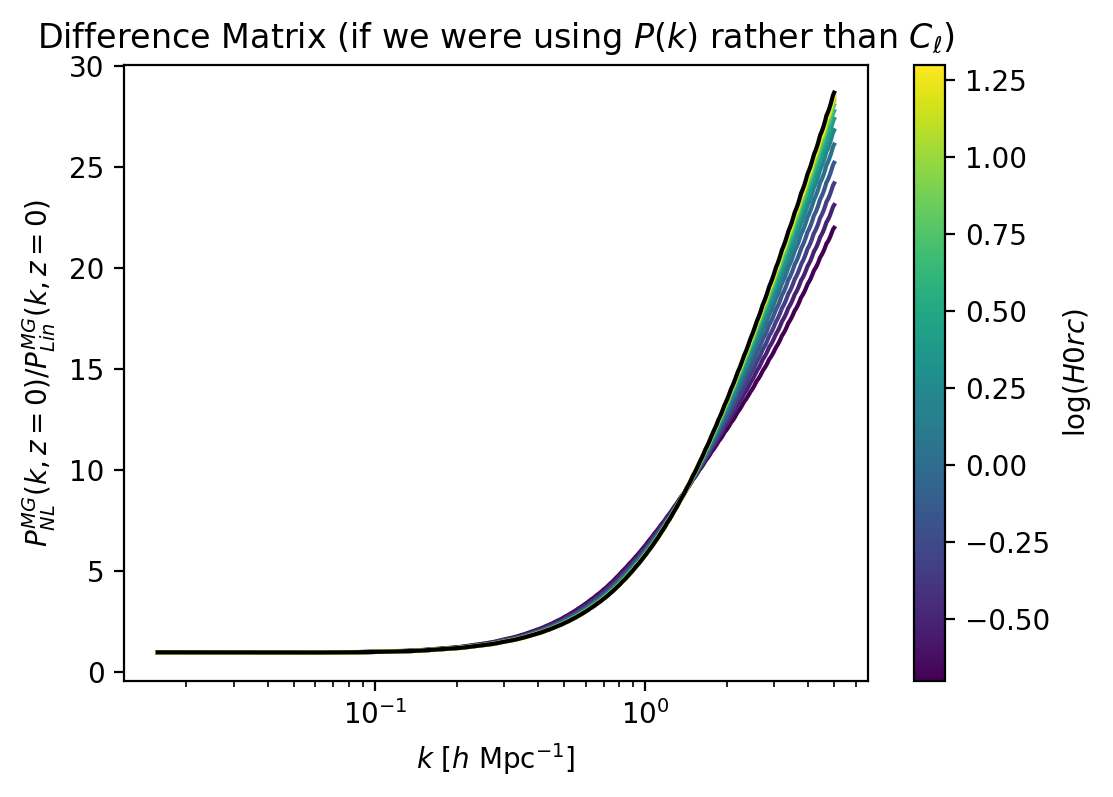

In [25]:
"""Plotting the NL power spectra for the simulations at z = 0"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['viridis']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = np.log10(H0rc_arr)
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('log($H0rc$)', rotation=90)

for i in range(len(arr_params[0])):
    ax.semilogx(NL_Pk_arr[0], NL_Pk_arr[i+1] / np.interp(NL_Pk_arr[0],lin_Pk_arr[0],lin_Pk_arr[i+1]),color = cmap(frac0[i]), label="z = 0")

ax.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1] / np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]), color="k")

#ax.plot(kk, Pk_NLCCL / Pk_linCCL, color="k")

ax.set_ylabel("$P^{MG}_{NL}(k, z=0) / P^{MG}_{Lin}(k, z=0)$")

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax.set_title("Difference Matrix (if we were using $P(k)$ rather than $C_{\ell}$)")

plt.show()

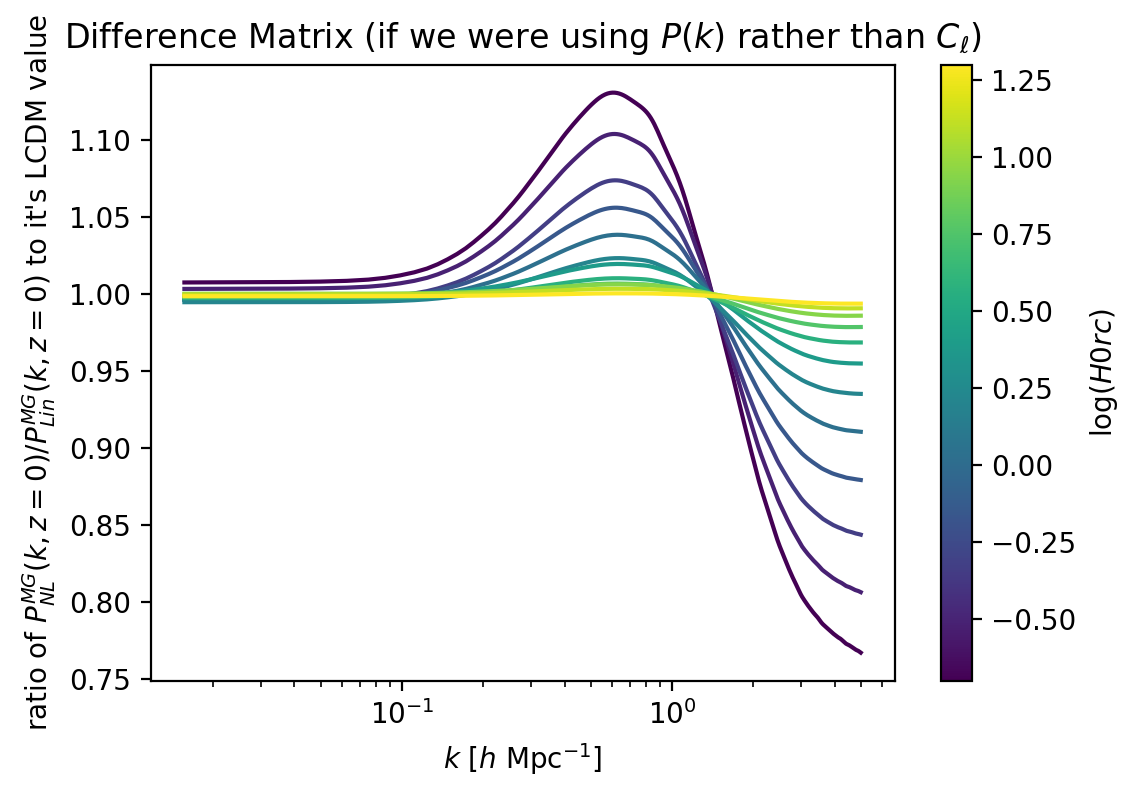

In [26]:
"""Plotting the NL power spectra for the simulations at z = 0"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['viridis']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = np.log10(H0rc_arr)
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('log($H0rc$)', rotation=90)

for i in range(len(arr_params[0])):
    zeroth = NL_Pk_arr_gr[1] / np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0], lin_Pk_arr_gr[1])
    ax.semilogx(NL_Pk_arr[0], NL_Pk_arr[i+1] / np.interp(NL_Pk_arr[0],lin_Pk_arr[0],lin_Pk_arr[i+1]) / zeroth ,color = cmap(frac0[i]), label="z = 0")

#ax.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1] / np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]), color="k")

#ax.plot(kk, Pk_NLCCL / Pk_linCCL, color="k")

ax.set_ylabel("ratio of $P^{MG}_{NL}(k, z=0) / P^{MG}_{Lin}(k, z=0)$ to it's LCDM value")

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax.set_title("Difference Matrix (if we were using $P(k)$ rather than $C_{\ell}$)")

plt.show()

## ReACT plots

In [33]:
arr = np.loadtxt("Lin_NL_nDGP_pk.txt")


In [34]:
k_ReACT = arr[0]
pofk_lin_MG_react = arr[13:]
pofk_NL_MG_react = arr[1:13]

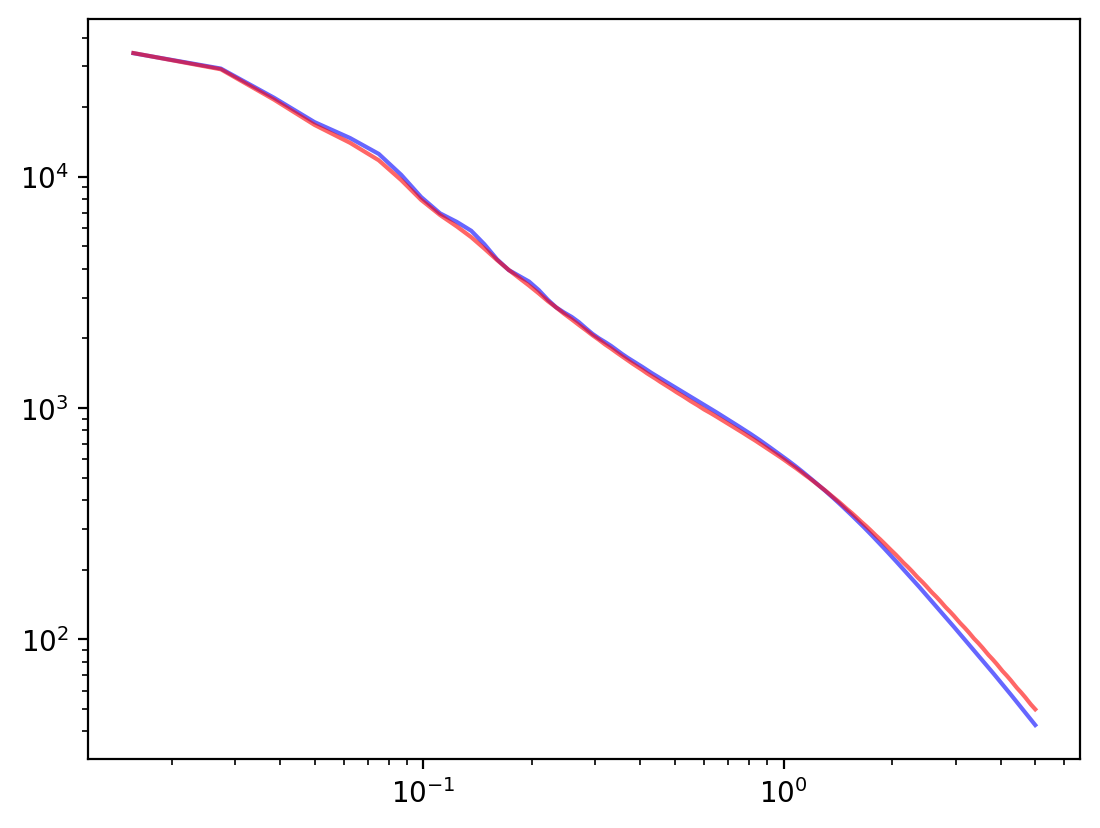

In [35]:
for i in range(1):
    
    plt.plot(NL_Pk_arr[0], NL_Pk_arr[i+1], "b", alpha=0.6)
    plt.plot(NL_Pk_arr[0], np.interp(NL_Pk_arr[0],k_ReACT,pofk_NL_MG_react[i]), "r", alpha=0.6)


#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)

plt.xscale("log")
plt.yscale("log")


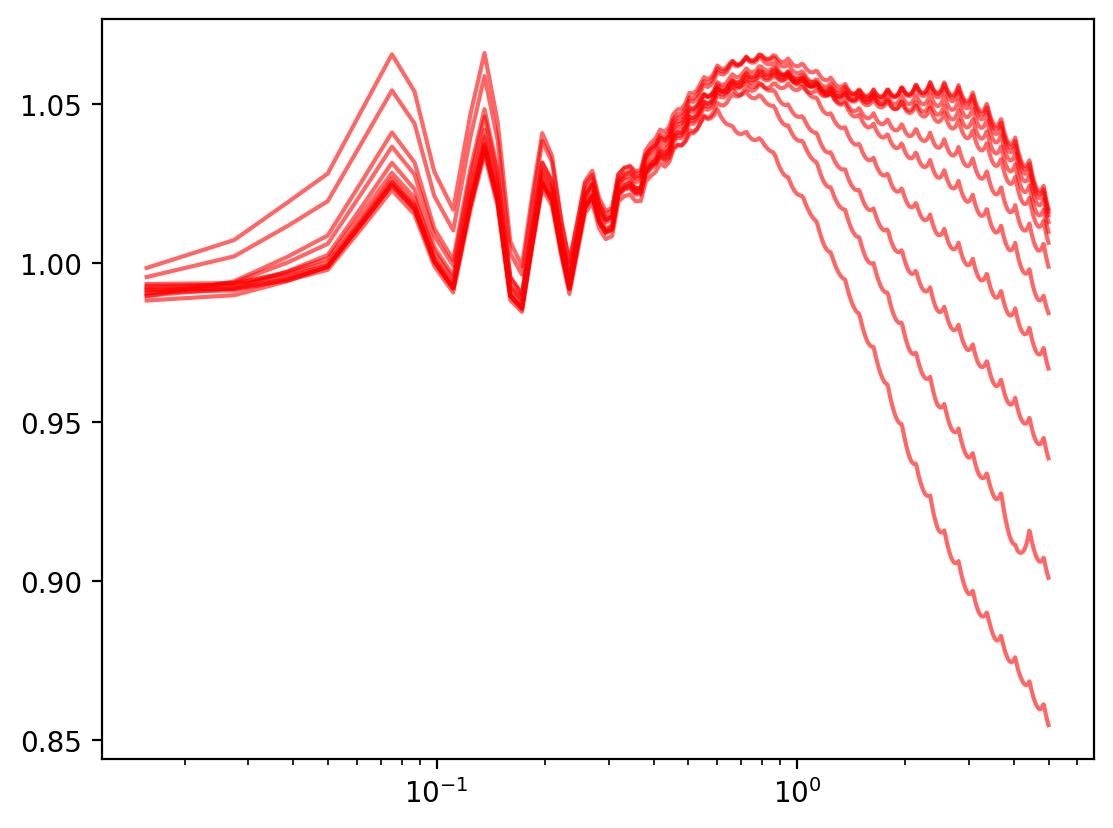

In [36]:
for i in range(len(arr_params[0])):
    plt.plot(NL_Pk_arr[0], NL_Pk_arr[i+1]/np.interp(NL_Pk_arr[0],k_ReACT,pofk_NL_MG_react[i]), "r", alpha=0.6)


#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)
ax.set_ylabel("$P^{MG, NL}_{mgemu} / P^{MG,NL}_{react}(k, z=0)$")

plt.xscale("log")


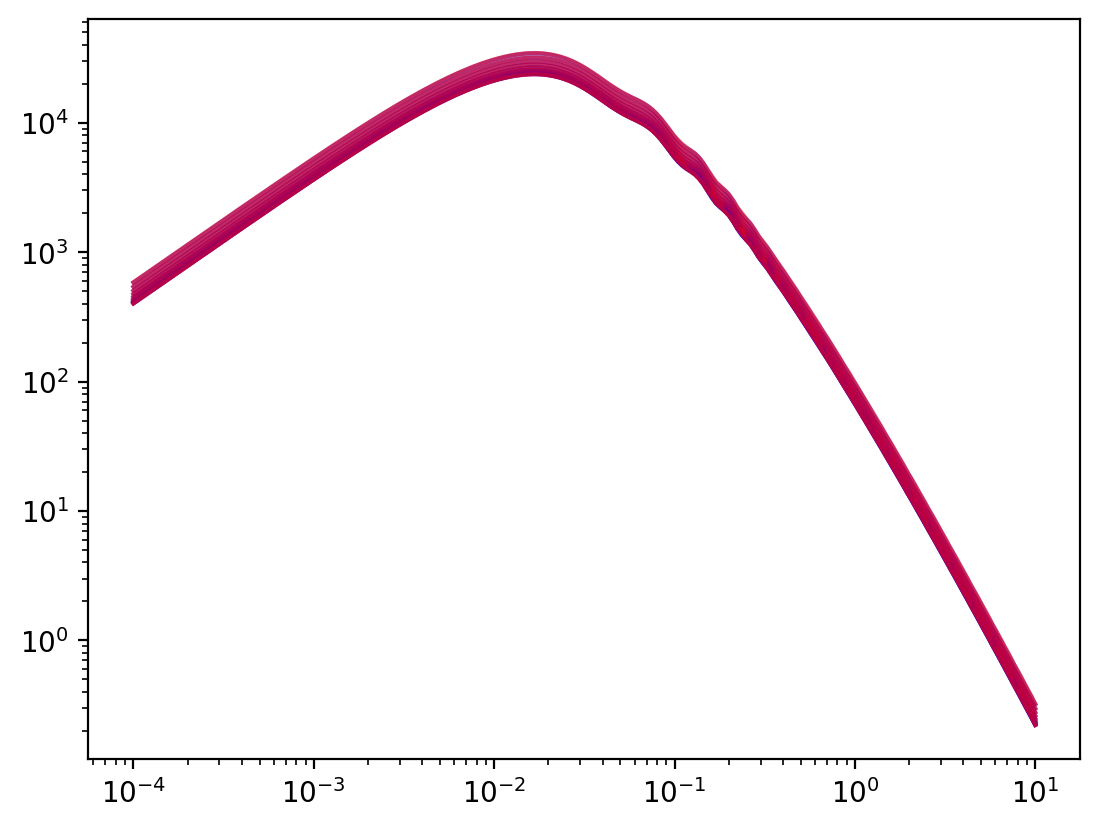

In [37]:
for i in range(len(arr_params[0])):
    
    plt.plot(lin_Pk_arr[0], lin_Pk_arr[i+1], "b", alpha=0.6)
    plt.plot(lin_Pk_arr[0], np.interp(lin_Pk_arr[0],k_ReACT,pofk_lin_MG_react[i]), "r", alpha=0.6)


#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)

plt.xscale("log")
plt.yscale("log")


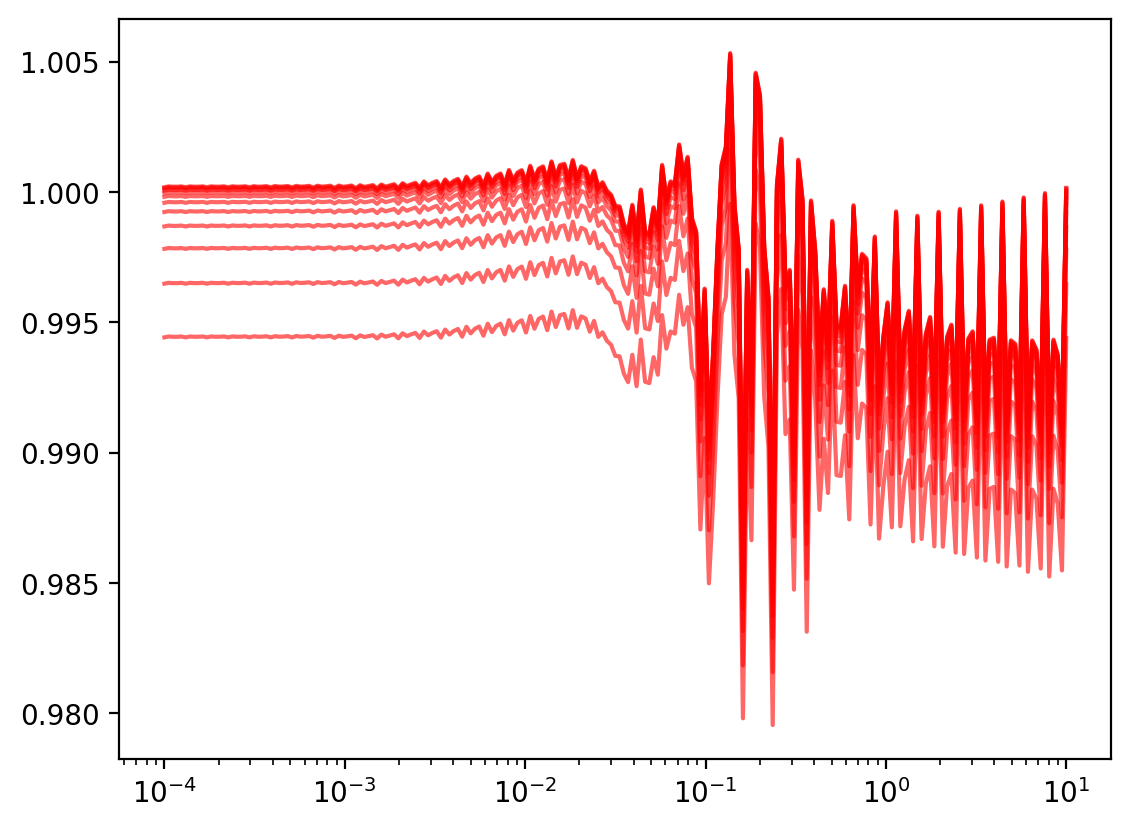

In [38]:
for i in range(len(arr_params[0])):
    
    plt.plot(lin_Pk_arr[0], lin_Pk_arr[i+1] / np.interp(lin_Pk_arr[0],k_ReACT,pofk_lin_MG_react[i]), "r", alpha=0.6)


#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)

plt.xscale("log")


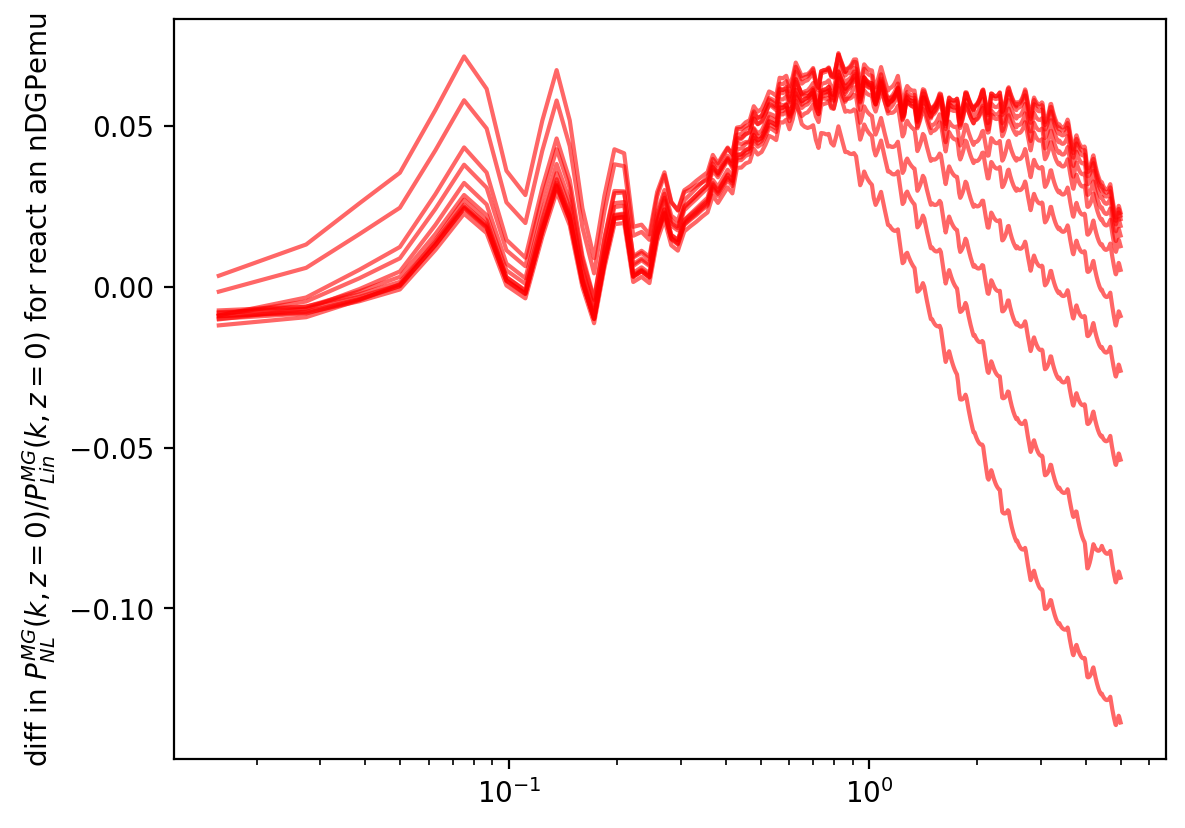

In [39]:
for i in range(len(arr_params[0])):
    
    
    plt.plot(NL_Pk_arr[0], NL_Pk_arr[i+1]/np.interp(NL_Pk_arr[0],lin_Pk_arr[0],lin_Pk_arr[i+1]) /
             (
                 np.interp(NL_Pk_arr[0],k_ReACT,pofk_NL_MG_react[i]) / np.interp(NL_Pk_arr[0],k_ReACT,pofk_lin_MG_react[i])
             ) - 1
             , "r", alpha=0.6)



#plt.plot(lin_ccl_Pk_arr_gr[0], lin_ccl_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1],color="k")
#plt.loglog(lin_Pk_arr_gr[0], lin_Pk_arr_gr[1],color="k")
#plt.plot(NL_Pk_arr_gr[0],np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0],lin_Pk_arr_gr[1]), "r", alpha=0.6)
plt.ylabel("diff in $P^{MG}_{NL}(k, z=0) / P^{MG}_{Lin}(k, z=0)$ for react an nDGPemu")

plt.xscale("log")


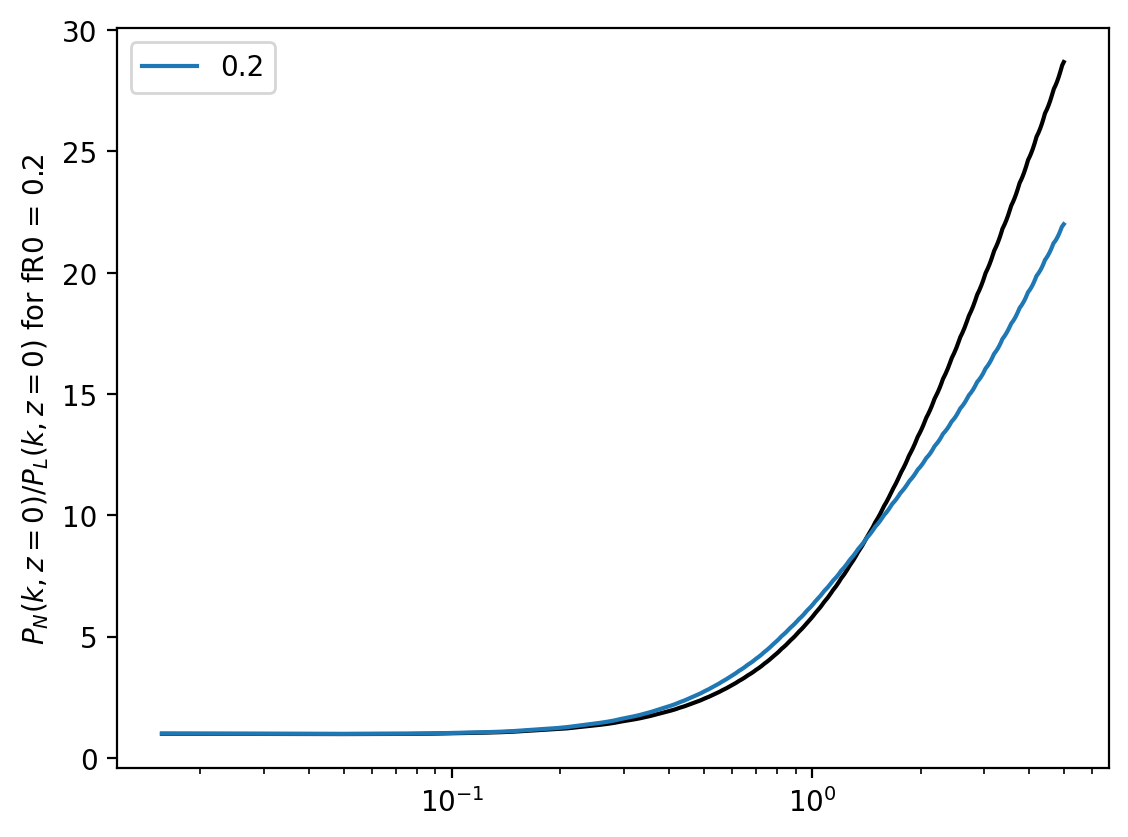

In [40]:
idx = 0 # pos. count only
plt.plot(NL_Pk_arr_gr[0], NL_Pk_arr_gr[1] / np.interp(NL_Pk_arr_gr[0],lin_Pk_arr_gr[0], lin_Pk_arr_gr[1]), color="k")
#plt.plot(k_ReACT, pofk_NL_MG_react[-1] / pofk_lin_MG_react[-1], label="z = 0")
plt.plot(NL_Pk_arr[0], NL_Pk_arr[idx + 1] / np.interp(NL_Pk_arr[0],lin_Pk_arr[0],lin_Pk_arr[idx + 1]),label=str(H0rc_arr[idx]))

plt.ylabel(r"$P_N(k, z=0) / P_L(k, z=0)$ for fR0 = {}".format(H0rc_arr[idx]))

plt.legend()
plt.xscale("log")